In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [4]:
def factor(df, window=20):
    """
    改进：使用分位数回归替代OLS，自适应不同市场环境
    金融意义：在极端市场条件下保持稳健性
    """
    df = df.copy()
    df['return'] = (df['close'] - df['open']) / df['open']
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        time_idx = np.arange(len(group))
        # 自适应分位数计算
        q_up = np.clip(group['return'].quantile(0.75), 0.001, 0.05)
        q_down = np.clip(group['return'].quantile(0.25), -0.05, -0.001)
        
        # 分位数过滤
        up_mask = group['return'] > q_up
        down_mask = group['return'] < q_down
        
        if up_mask.any():
            up_weights = group.loc[up_mask, 'return'].abs() * group.loc[up_mask, 'volume']
            G_u = np.sum(time_idx[up_mask] * up_weights) / up_weights.sum()
        else:
            G_u = np.nan
            
        if down_mask.any():
            down_weights = group.loc[down_mask, 'return'].abs() * group.loc[down_mask, 'volume']
            G_d = np.sum(time_idx[down_mask] * down_weights) / down_weights.sum()
        else:
            G_d = np.nan
            
        daily_results.append({
            'date': date,
            'G_u': G_u,
            'G_d': G_d,
            'volatility': group['return'].std()
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    # 分位数回归
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i].dropna()
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
            
        # 根据波动率选择分位数
        current_vol = daily_df.iloc[i]['volatility']
        quantile = 0.3 if current_vol > daily_df['volatility'].quantile(0.75) else 0.5
        
        X = train_data[['G_u']].values
        y = train_data['G_d'].values
        model = QuantileRegressor(quantile=quantile, alpha=0).fit(X, y)
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_u']) or pd.isna(current['G_d']):
            residuals.append(np.nan)
        else:
            pred_G_d = model.predict([[current['G_u']]])[0]
            residuals.append(current['G_d'] - pred_G_d)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # 波动率调整因子值
    vol_adjust = daily_df['volatility'] / daily_df['volatility'].rolling(20).mean()
    daily_df['factor'] = daily_df['residual'].rolling(window).mean() * vol_adjust
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return -df['factor_value']

# 测试因子表现


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.018167
   Rank_IC (Spearman): 0.021250
📊 信息比率:
   IR: 0.229478
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 127291
   因子列: factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------


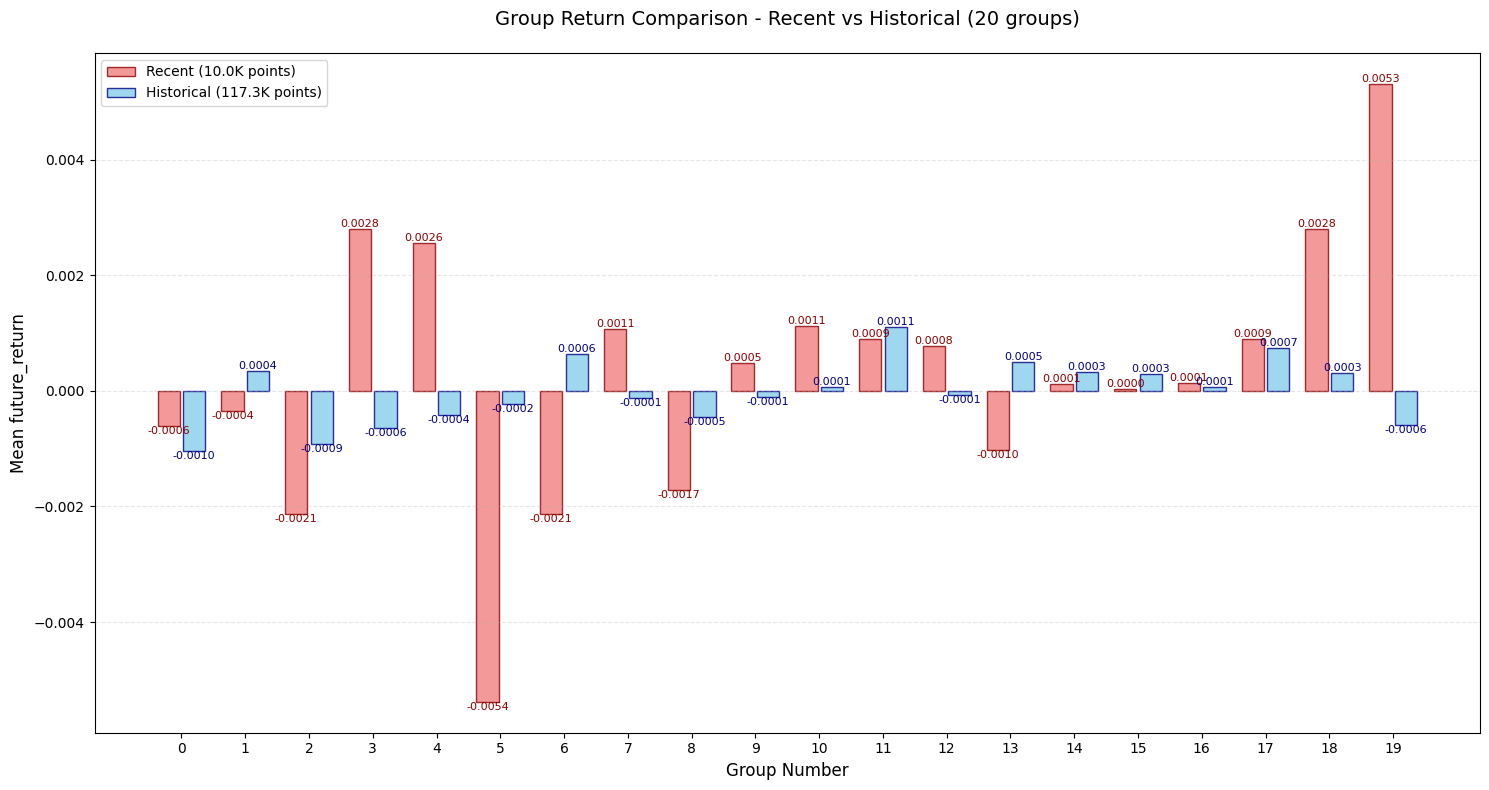

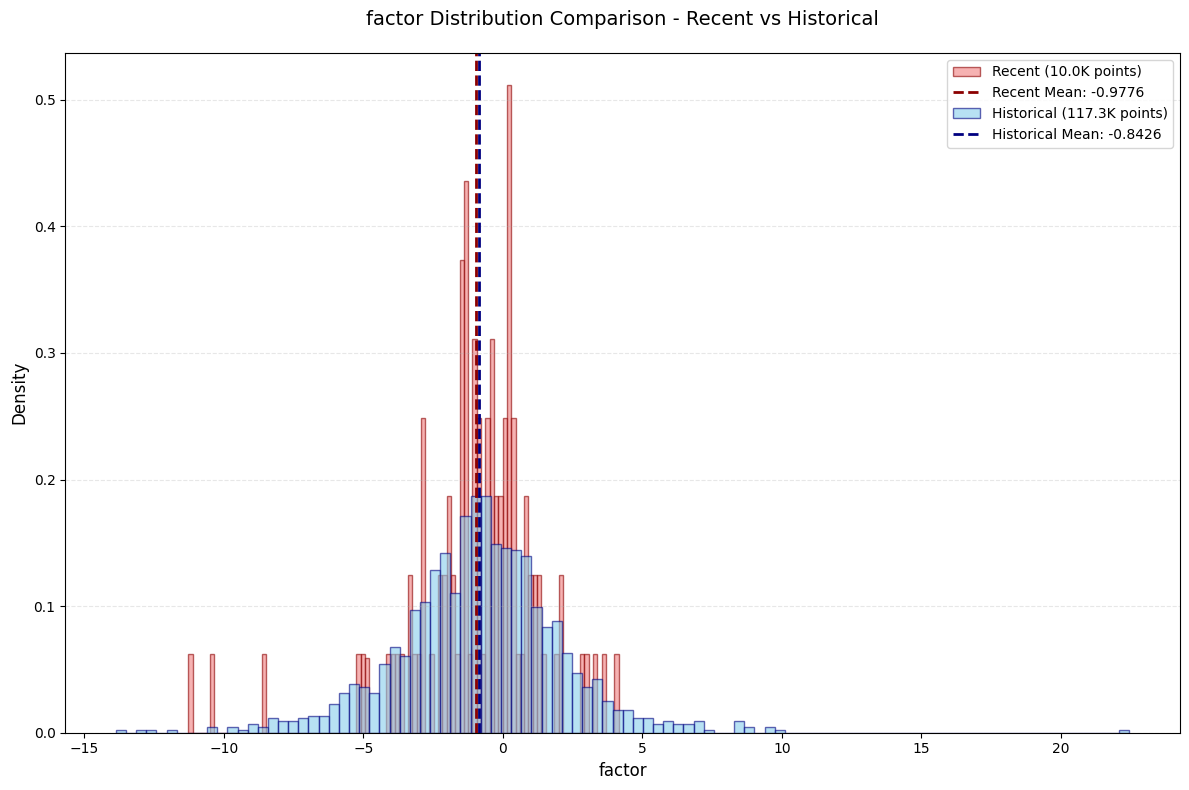

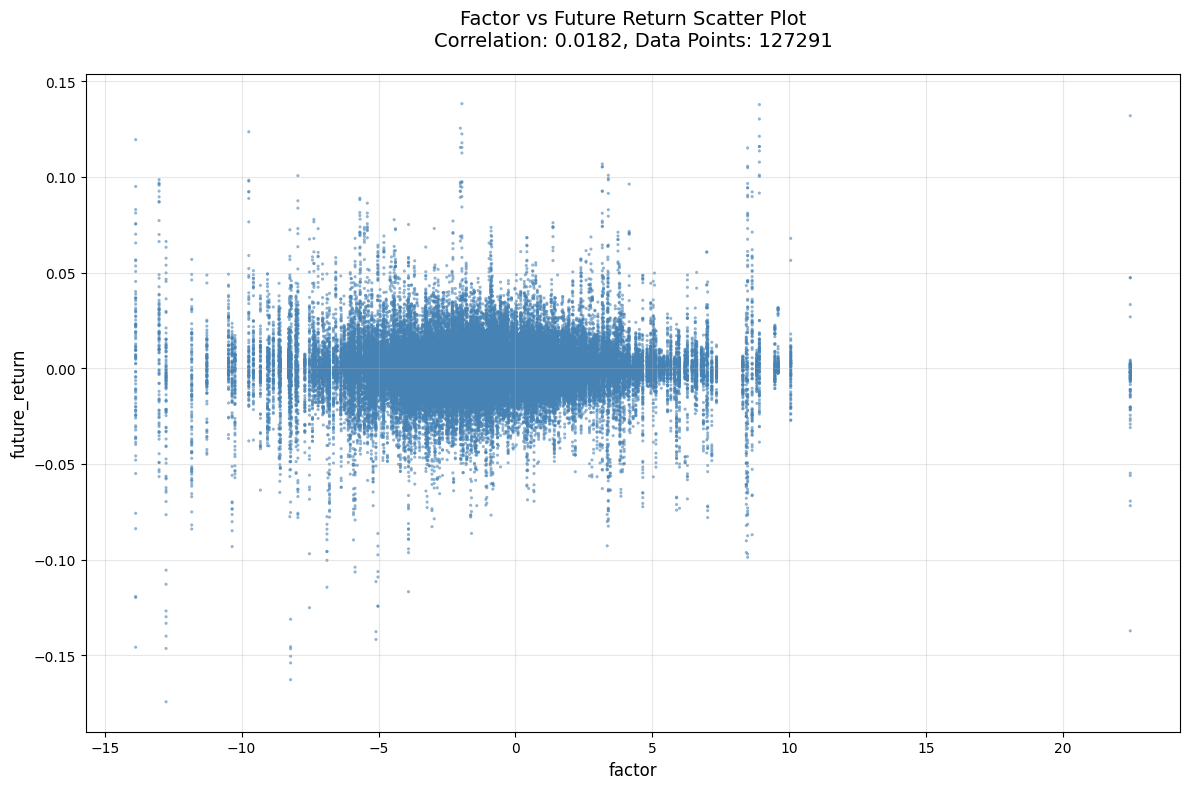

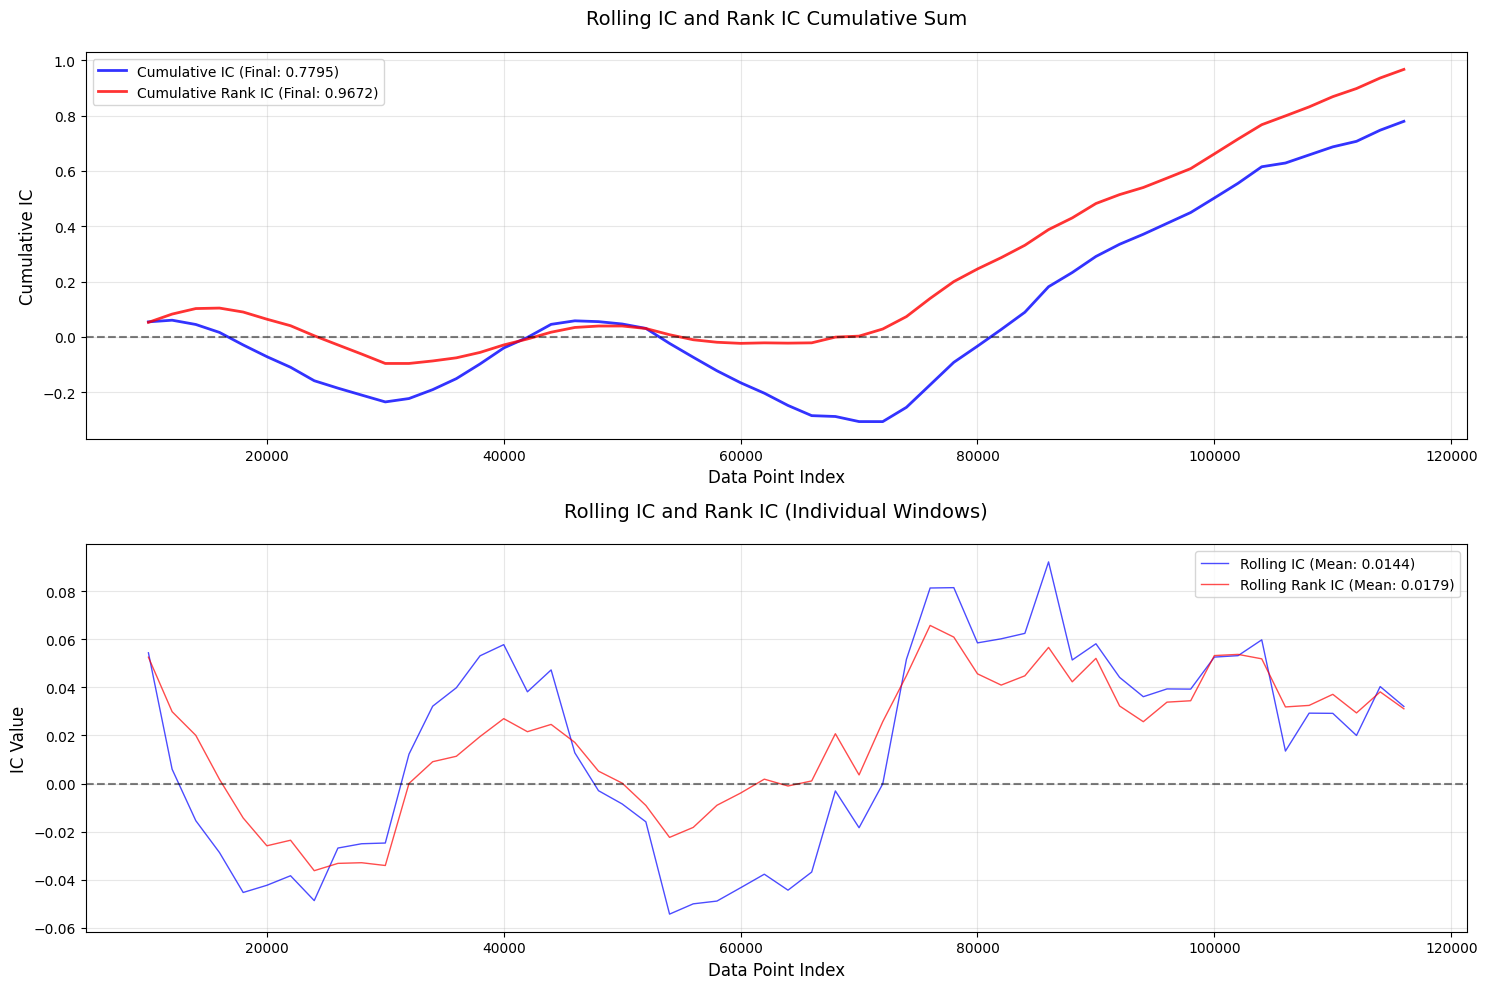

✅ 已显示 4 个图片
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [6]:
result['information_ratio']['group_correlations']
# 这表示不同分组之间的相关性，通常用于评估因子在不同市场状态下的表现一致性。
# 如果相关性较高，说明因子在不同市场状态下表现一致；如果相关性较低，说明因子在不同市场状态下表现差异较大。

[0.01899322610294405,
 0.011654328979317561,
 0.022351488204491256,
 -0.04251541736925123,
 0.02029554690388856,
 0.023810478306916686,
 0.026027096615633537,
 0.017297844980337596,
 0.00909054240315541,
 -0.04743986286298941]

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.01816723345638689, 'Rank_IC': 0.021250093971288943}, 'information_ratio': {'IR': 0.22947830472661182, 'group_correlations': [0.01899322610294405, 0.011654328979317561, 0.022351488204491256, -0.04251541736925123, 0.02029554690388856, 0.023810478306916686, 0.026027096615633537, 0.017297844980337596, 0.00909054240315541, -0.04743986286298941], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0     -13.8701  -5.6734   -7.6265      -0.0007      0.0218   6432
1      -5.6575  -4.2720   -4.8921      -0.0000      0.0156   6331
2      -4.2217  -3.4638   -3.8421      -0.0009      0.0134   6336
3      -3.4459  -2.8611   -3.1451      -0.0005      0.0122   6432
4      -2.8565  -2.4098   -2.6352      -0.0003      0.0107   6336
5      -2.3976  -2.0121   -2.2187       0.0001      0.0105   6336
6      -2.0118  -1.6334   -1.8493       0.00